# Surrogate Construction for Genz Functions with regression as a function of the number of training points

This notebook constructs a PC surrogate for Genz functions using random sampling and regression, giving the RMS error bewteen the surrogate and the actual function.

In [1]:
# imports
import numpy as np
import math  
import matplotlib.pyplot as plt
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Inputs

In [2]:
nord = 3           # Order of the PCE
pc_type = "LU"     # Polynomial type
pc_alpha = 0.0     # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
nSam = 10000       # Number of evaluation samples samples
max_dim=8          # Maximum number of dimensions to include
model= 'genz_osc'  # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

## Collecting Errors

We loop through different numbers of random samples to feed into regression and obtain the RMSE. We start with a number of samples equal to 90% of the basis terms and continue to 125%.

In [3]:
percent=[.9, .95, 1, 1.05, 1.10, 1.15, 1.2, 1.25] # fractions of the number of basis terms to use

# arrays to store error statistics for each dimension
mean_dim_errors=np.zeros((max_dim, len(percent)))
std_dim_errors=np.zeros((max_dim, len(percent)))

# loop through each dimension
for ndim in range(1, max_dim+1):
    
    # instantiate PC object
    pc_model = uqtkpce.PCSet("NISPnoq", nord, ndim,pc_type, pc_alpha,pc_beta)
    npce=pc_model.GetNumberPCTerms()
  
    # list to store stats for each percent
    mean_per_errors=[]
    std_per_errors=[]

    for per in percent:
        nTest=int(npce*per)
    
        # list to store stats for the 10 trials
        RMSE_list=[]
        
        for i in range(10):
            # train PC at random samples
            rand=np.random.normal(loc=0, scale=0.5, size=(nTest, ndim))
            f_evals=func(rand, model, np.ones(ndim+1))
            
            # find coefficients
            c_k=pce_tools.UQTkRegression(pc_model, f_evals, rand)
            
            # evaluate at random samples
            germ_samples=np.random.normal(0,1, (nSam,ndim))
            pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)
            
            # find error
            f_actual=func(germ_samples,model,np.ones(ndim+1))
            MSE = np.square(np.subtract(f_actual,pce_evals)).mean()
            RMSE=math.sqrt(MSE)
            RMSE_list.append(RMSE)
            
        # add the results of the 10 trials    
        mean_per_errors.append(np.array(RMSE_list).mean())
        std_per_errors.append(np.std(np.array(RMSE_list)))

    mean_dim_errors[ndim-1]=mean_per_errors
    std_dim_errors[ndim-1]=std_per_errors

## Summary
This table and figure display the error of each number of training points for each dimension. The number of training points varies as a percentage of the number of basis terms.

In [4]:
row_label=["dim "+str(i) for i in range(1, max_dim+1)]
pd.DataFrame(data=mean_dim_errors, index=row_label, columns=percent)

,0.90,0.95,1.00,1.05,1.10,1.15,1.20,1.25
dim 1,0.537094,0.842523,0.027295,0.028194,0.025218,0.030412,0.027533,0.022276
dim 2,0.329896,0.534586,0.401817,0.086041,0.080234,0.072204,0.065916,0.053751
dim 3,0.350165,0.194720,0.277164,0.208224,0.110968,0.126980,0.079968,0.109123
dim 4,0.520157,0.391722,4.171071,0.694852,0.290574,0.292553,0.190064,0.248286
dim 5,0.755837,0.712355,1.998665,0.835114,0.769707,0.537954,0.425413,0.415742
dim 6,1.024277,1.003036,4.893425,1.281153,0.967028,0.970612,0.773312,0.603642
dim 7,0.987870,1.634468,4.945653,1.261465,1.042216,0.889332,0.808235,0.764833
dim 8,1.068375,1.112305,50.463470,1.548767,0.992067,0.877780,0.811012,0.687632


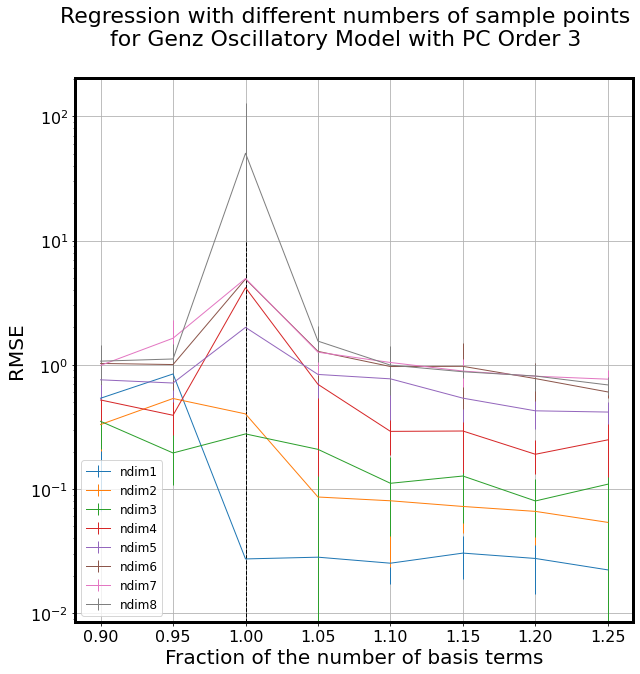

In [5]:
# Create figure
fig, ax = plt.subplots(figsize=(10,10))

# Plot Error Data
for ndim in range(1, max_dim +1):
    plt.errorbar(percent, mean_dim_errors[ndim-1], yerr=std_dim_errors[ndim-1], xerr=None, label=str('ndim'+str(ndim)))

# Line where number of samples = number of basis terms
plt.vlines(x = 1, ymin = 0, ymax = 10, colors = 'black', linestyle="dashed")

# Label Axes
plt.xlabel("Fraction of the number of basis terms",fontsize=20)
plt.ylabel("RMSE",fontsize=20)

# Create legend
plt.legend(loc='lower left')

# Model titles to be displayed
if model=="genz_osc":
    model_title="Genz Oscillatory"
elif model=="genz_gaus":
    model_title="Genz Gaussian"
elif model=="genz_ppeak":
    model_title="Genz Product-Peak"
elif model=="genz_cpeak":
    model_title="Genz Corner-Peak"
elif model=="genz_exp":
    model_title="Genz Exponential"
else:
    model_title="Genz Continuous"

# Add title
fig.suptitle("Regression with different numbers of sample points\nfor %s Model with\
 PC Order %s"%(model_title, str(nord)), fontsize=22)

# Change y scale
plt.yscale('log')

#Change size of tick labels
plt.tick_params(axis='both', labelsize=16)

#Show figure
plt.show() 